# A simple demo of the residualmlp python package
## This is a regression case pure resudual multi layer perceptron with no base model. 

1. Purpose:
    1. This is a simple demo of the residualmlp python package that generates resisual_mlp models.
2. Please note:
    1. This version of the demo neither demonstrates an optimal neural network architecture nor does any preprocessing on the data, even though doing so would boost the performance of the model.This demo sumply demonstrates how to use the API and the syntax.
    2. For a more complete example, see the demo for the tandem EfficientNetB7->residualMLP model discussed in the readme.md.

In [1]:
# Install anything missing
!python -m pip install upgrade pip
!pip3 install matplotlib
!pip3 install pandas

ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 11.3 MB 20.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 28.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 27.9 MB/s eta 0:00:01
     |████████████████████████████████| 890 kB 31.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 11.5 MB 23.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
# Import what we need ...
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from residualmlp.residual_mlp import ResidualMLP

In [3]:
# Read the California housing data. 
df = pd.read_csv("https://storage.googleapis.com/ml_universities/california_housing_train.csv", sep=",")

In [4]:
# Let's see what this looks like.
# In the real world, data would never be this clean... 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [5]:
# In a use-worthy model, we would bucketize and cross the lattitude and longitude.
# and probably bucketize several of the continuous variables
# Here we are just doing a simple example to demo how to work our API

In [6]:
# pseudo quasi random numbers between 0 and 1. 
# ~ 80% of them should be below .8 
msk = np.random.rand(len(df)) < 0.8
traindf = df[msk]
evaldf = df[~msk]
traindf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0
5,-114.58,33.63,29.0,1387.0,236.0,671.0,239.0,3.3438,74000.0


In [7]:
# Pull label from df
y_train = traindf.pop('median_house_value')

In [8]:
# Convert label to a numpy array
y_train = y_train.to_numpy()

In [9]:
# Pull label from df
y_eval = evaldf.pop('median_house_value')

In [10]:
# Convert label to a numpy array
y_eval = y_eval.to_numpy()

In [11]:
# Convert data - the features to a numpy array
x_train = traindf.to_numpy()

In [12]:
# Convert data - the features to a numpy array
x_eval = evaldf.to_numpy()

## Here we build our model: 
### We start by setting the hyperparameters:

1. LEARNING_RATE / learning_rate: The learning rate for the optimizer.
2. INPUT_SHAPE, input_shape: The input shape for the model as a whole, In other words, the shape of one observation in your data. In our case, each observation has 9 columns. One was removed as the label, so 8 columns, so shape is 8.
3. BASE_MODEL / base_model: If you were building a tandem model, starting with a pre-trained base model and passing the output of that model to the residual MLP we are building, then you would pass in that keras model object (e.g. and EfficientNetB7 model.). In the case of this demo, we are not doing this. We are passing our data and labels straight into a residual MLP, so base_model will be set to empty string '':
4. BASE_MODEL_INPUT_SHAPE / base_model_input_shape: If you are using a base model with a different input shape than your data, you would enter the input shape for the base model, and the model built by make_model() would include a rescaling layer before between your input layer and your base model. For example, if you have training / test images of shape (32,32,3) and were using EfficientNet, pretrained on imagenet from keras applications having an input shape of (600,600,3), as your base_model, you would set the parameter 'base_model_input_shape' to (600,600,3).
5. Flatten: Whether or not to put a Flatten layer before your data passes into the residual multi layer perceptron being built. This is usually set to True if you have a Conv2d layer as the last layer of your base model or otherwise have any data that will pass to your residualMLP model that is not a rank 1 tensor. Settign it to true will coerce the data being fed into your residualMLP model to a rank tensor. If you are building a tandem ConvolutionalNeuraNetworkModel->residualMLP model, this must be set to true, or the shape will raise an exception at the Concat layer(s) in the residualMLP model being built. Here, each observation is a rank 1 tensor, and it is going straight into our model with no upstream operation that will change its rank, so there is nothing to flatten. Flatten is set to False.
6. BLOCKS / blocks: A 2d array. Each ith nested array will create a residualMLP block. See the image in readme.md for a visual of this. In each ith nested arry, you will find 3 positive integers (except l which can be positive or may be 0): j,k,l (from left to right). The positive integer j on the left of each nested array gives you control of how many Dense layers that this block will consist of. The second positive integer, k sets the number of Dense units in the first layer of the block. The third [0 or positive integer] l is how many LESS Dense units each succesive layer in the block will consist of than its predecessor. There is one additional obvious rule that the product of the first and third numbers, j and l must be < k, the second number, otherwise, you are asking the API to add some layer(s) with O Dense units or a negative number of Dense units. This will of course raise an exception and make you feel as embarassed as I did the first time I did this 😳. As a reminder, you must be concious of this when trying to run an auto-ml algorithym or running a gridsearch over permutations of these hyperparameters. A try .. except ... or better yet, a pre-screening of these permutations will be needed.
7. RESIDUAL_BYPASS_DENSE_LAYERS / residual_bypass_dense_layers: If you want to include (a) Dense layer(s) in the residual bypass tensor, you would set this to a 2d array as we did below [[3],[3]], this will place a Dense layer with 3 units in the residual bypass of Block 1 and will place another Dense layer with 3 units in the resisual bypass of block 2. By default this is empty string "". If you set this, there must be a nested list for each blcok and may eb as many numbers in each blcok as your isel model architecture will have. Each ith nested 1d array would control the Dense layers in the residual bypass for the ith residual block. One layer will be inserted for each positive integer in the nested list and each layer will have the number of units as the integer.  If this is left as the default of '', then there will be no blocks in the residual bypass. You may add layers to one blocks's bypass and not the other like this: [[],[5]] See the image on readme.md. For this to make sense, please see the image on readme.md.The residual bypass is the through the network in yellow nodes on the right.).
8. B_NORM_OR_DROPOUT_RESIDUAL_BYPASS_LAYERS / b_norm_or_dropout_residual_bypass_layers: You may insert BatchNormalization or dropout layers after each layer of the residual bypass. Options: Default "dropout" | "bnorm".
9. DROPOUT_RATE_FOR_BYPASS_LAYERS / dropout_rate_for_bypass_layers: The global dropout rate for the dropout laters in the RESIDUAL BYPASSES (ignored if B_NORM_OR_DROPOUT_RESIDUAL_BYPASS_LAYERS is set to 'bnorm'). This usually performs best as dropout and often with a higher DROPOUT_RATE_FOR_BYPASS_LAYERS (e.g. 25%).
10. B_NORM_OR_DROPOUT_LAST_LAYERS / b_norm_or_dropout_last_layers: After all last residual block, the hyperparameter FINAL_DENSE_LAYERS allows you to add a series (or just one) Dense layer(s). The hyperparameter b_norm_or_dropout_last_layers controls whether there will be a Dropout or BatchNormalization layer after each of these layer(s). This defaults to 'dropout' but can be set to 'bnorm'. It seems that about 60% of the time, dropout with the right dropout_rate will perform best, but be advised that these layers are more apt to internal covariate shift than the residual bypass layers. You amy want to experiment with both.  
11. DROPOUT_RATE / dropout_rate: The dropout rate for the dropout layers after each final Dense layer inserted after the last residualMLP block by the parameter   
12. FINAL_DENSE_LAYERS / final_dense_layers: A 1d array of positive integers: Each ith positive integer will insert a Dense layer after the last ResidualMLP block.
13. NUMBER_OF_CLASSES = how many Dense units the final layer of the network should consist of / also the number of classes in your labels. For example, a simple linear regression model would have this parameter set to 1. So would a binary logistic regression problem. For a multi - class - classification problem, it would be the number of classes, eg 10 for a classification problem where there are 10 possible classes.
14. FINAL_ACTIVATION - The activatinn fucntion e.g. tf.keras.activations.sigmoid - [no parentheses after it]. It defaults to tf.keras.activations.softmax. Since we are doing simple linear regression, the activation is None.
15. LOSS - The loss that is appropriate for your problem. Here we are doign simpel linear regression, so the default chice is f.keras.losses.MeanSquaredError(), but tf.keras.losses.Huber() and tf.keras.losses.MeanAbsoluteError() are fair game. The default is: tf.keras.losses.CategoricalCrossentropy(from_logits=False), but that doesn't help us with this problem ... so we set it to None.

In [22]:
# Set the hyperparameters for the  

PROBLEM_TYPE = 'regression'
LEARNING_RATE = 0.007
INPUT_SHAPE = 8
BASE_MODEL = ''
BASE_MODEL_INPUT_SHAPE = None
FLATTEN = False
BLOCKS = [[5,12,2],[5,12,2]]
RESIDUAL_BYPASS_DENSE_LAYERS = [[3],[3]]
B_NORM_OR_DROPOUT_RESIDUAL_BYPASS_LAYERS = 'bnorm'
DROPOUT_RATE_FOR_BYPASS_LAYERS = 0.0
B_NORM_OR_DROPOUT_LAST_LAYERS = 'bnorm'
DROPOUT_RATE = 0.0
FINAL_DENSE_LAYERS = [4,4]
NUMBER_OF_CLASSES = 1
FINAL_ACTIVATION = None
LOSS = tf.keras.losses.MeanSquaredError()

In [23]:
res_mlp = ResidualMLP(problem_type = PROBLEM_TYPE,
                      learning_rate=LEARNING_RATE,
                      input_shape = INPUT_SHAPE,  
                      base_model= BASE_MODEL,
                      base_model_input_shape = BASE_MODEL_INPUT_SHAPE,
                      flatten_after_base_model = FLATTEN,
                      blocks = BLOCKS,
                      residual_bypass_dense_layers = RESIDUAL_BYPASS_DENSE_LAYERS,
                      b_norm_or_dropout_residual_bypass_layers=B_NORM_OR_DROPOUT_RESIDUAL_BYPASS_LAYERS,
                      dropout_rate_for_bypass_layers=DROPOUT_RATE_FOR_BYPASS_LAYERS,
                      b_norm_or_dropout_last_layers=B_NORM_OR_DROPOUT_LAST_LAYERS,
                      dropout_rate=DROPOUT_RATE,
                      final_dense_layers =\
                          FINAL_DENSE_LAYERS,
                      number_of_classes = NUMBER_OF_CLASSES,
                      final_activation = FINAL_ACTIVATION,
                      loss = LOSS)
model0001=\
    res_mlp.make_tandem_model()

In [24]:
model0001.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 12)           108         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 12)           48          dense_19[0][0]                   
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 12)           156         batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [16]:
BATCH_SIZE = 50
EPOCHS = 100
PATIENCE = 15
PATIENCE_MIN_DELTA = .005

In [17]:
logdir = os.path.join("2022-01-10_21-27_logs", 'results')
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, 
                                                      histogram_freq=1)

2022-01-10 08:28:48.051990: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-10 08:28:48.052240: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-10 08:28:48.053281: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-01-10 08:28:48.338206: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-10 08:28:48.338480: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


In [25]:
history = model0001.fit(x=x_train,  
                    y=y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,      
                    verbose='auto', 
                    callbacks=[tf.keras.callbacks.\
                               EarlyStopping(monitor='val_loss',
                                             patience=PATIENCE,
                                             min_delta=PATIENCE_MIN_DELTA,
                                             restore_best_weights=True),
                            tensorboard_callback], 
                    validation_split=0.3, 
                    validation_data=None, 
                    shuffle=True,
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0, 
                    steps_per_epoch=None, 
                    validation_steps=None, 
                    validation_batch_size=10, 
                    validation_freq=1, 
                    max_queue_size=10, 
                    workers=5, 
                    use_multiprocessing=True)

Epoch 1/100
  1/191 [..............................] - ETA: 19:18 - loss: 63094603776.0000 - root_mean_squared_error: 251186.3906 - mean_absolute_error: 221842.0625

2022-01-10 08:34:38.117827: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-10 08:34:38.118328: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/191 [..............................] - ETA: 1:54 - loss: 53686358016.0000 - root_mean_squared_error: 231703.1719 - mean_absolute_error: 204178.0469 

2022-01-10 08:34:38.472165: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-10 08:34:38.472720: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2022-01-10 08:34:38.530472: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1693 callback api events and 1707 activity events. 
2022-01-10 08:34:38.578807: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


  3/191 [..............................] - ETA: 1:33 - loss: 50268131328.0000 - root_mean_squared_error: 224205.5469 - mean_absolute_error: 196197.3594

2022-01-10 08:34:38.672914: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: 2022-01-10_21-27_logs/results/train/plugins/profile/2022_01_10_08_34_38

2022-01-10 08:34:38.706195: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to 2022-01-10_21-27_logs/results/train/plugins/profile/2022_01_10_08_34_38/nwsk1kktjk.trace.json.gz
2022-01-10 08:34:38.796527: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: 2022-01-10_21-27_logs/results/train/plugins/profile/2022_01_10_08_34_38

2022-01-10 08:34:38.803875: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to 2022-01-10_21-27_logs/results/train/plugins/profile/2022_01_10_08_34_38/nwsk1kktjk.memory_profile.json.gz
2022-01-10 08:34:38.824964: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: 2022-01-10_21-27_logs/results/train/plugins/profile/

191/191 [==============================] - 14s 44ms/step - loss: 51957465088.0000 - root_mean_squared_error: 227941.7969 - mean_absolute_error: 198546.1719 - val_loss: 65752702976.0000 - val_root_mean_squared_error: 256422.8906 - val_mean_absolute_error: 226006.6250
Epoch 2/100
191/191 [==============================] - 7s 35ms/step - loss: 51948548096.0000 - root_mean_squared_error: 227922.2344 - mean_absolute_error: 198528.5469 - val_loss: 65744580608.0000 - val_root_mean_squared_error: 256407.0625 - val_mean_absolute_error: 225995.6250
Epoch 3/100
191/191 [==============================] - 6s 29ms/step - loss: 51930972160.0000 - root_mean_squared_error: 227883.6719 - mean_absolute_error: 198496.4375 - val_loss: 65748152320.0000 - val_root_mean_squared_error: 256414.0156 - val_mean_absolute_error: 226012.0156
Epoch 4/100
191/191 [==============================] - 6s 30ms/step - loss: 51904770048.0000 - root_mean_squared_error: 227826.1875 - mean_absolute_error: 198449.8125 - val_loss

In [26]:
hy = pd.DataFrame(history.history)

<AxesSubplot:>

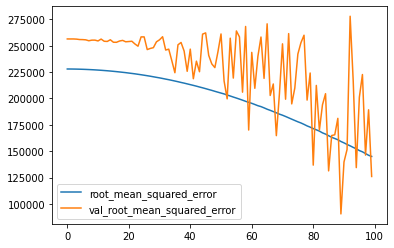

In [27]:
hy[['root_mean_squared_error','val_root_mean_squared_error']].plot()

In [28]:
model0001.save('2022-01-10_02-46_exported_ca_housing_model')

2022-01-10 08:47:15.762442: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: 2022-01-10_02-46_exported_ca_housing_model/assets


In [29]:
hy[['val_root_mean_squared_error']].min()

val_root_mean_squared_error    90564.664062
dtype: float64

In [30]:
hy[['val_root_mean_squared_error']].max()

val_root_mean_squared_error    277948.59375
dtype: float64

In [28]:
# Obviously this not a good run, overfitting, training data needs preprocessing, neural network. 
# architecture does not fit this specific problem, and several hyperparameters are way off,
# but ths does demonstrate the API aand syntax.
# I will post a better examle run later.